# Enron Fraud detection project
## Udacity Data Analyst Nano-Degree

*Jean-Philippe Navarro* ** Dec. 2017 **

## 1/ Project summary

The aim of this project is to investigate the possibility to identify Persons Of Interest (poi) of the famous [Enron case](https://en.wikipedia.org/wiki/Enron) using public informations made available during the Federal investigation:
- financial records
- e-mails exchanges between Enron employees

The problem is to be able to **classify** a given individual as poi or non-poi if we have financial and e-mails traffic information related to him/her.
Such **classification** problem can be solved using machine learning techniques.

The initial dataset is composed of 146 individuals described by 21 features.
Two outliers not corresponding to a physical individual had to be removed from the data-set : 
- TOTAL
- THE TRAVEL AGENCY IN THE PARK

The cleaned dataset was made of 144 individuals with 18 of them being flagged as poi. This can be considered as a quite unbalanced dataset:

|poi ratio | non-poi ratio|
|----------|--------------|
|   12.5%  | 87.5%        |




## 2/ Features analysis

Some features were not enough populated to be reasonably incoprporated into the analysis. A threshold of 85% missing values was set (see figure), resulting in the discard of the following ones:
- loan_advances
- director_fees
- restricted_stock_deferred

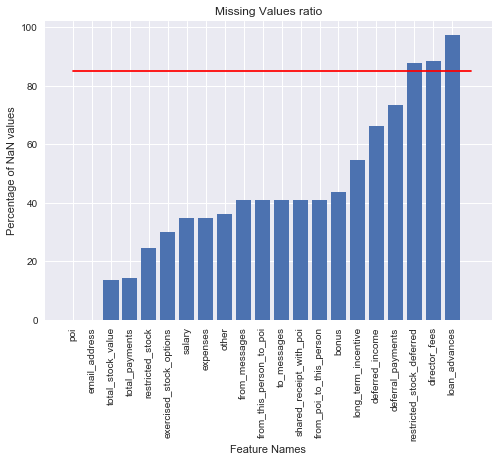


As first step, the initial features have been completed by building some ratio in order to capture relative importance of some characteristics versus a reference (total):
- For financial features:
    - $salary_{ratio} = \frac{salary}{total\_payments}$
    - $bonus_{ratio} = \frac{bonus}{total\_payments}$
    - $deferral\_payments_{ratio} = \frac{deferral\_payments}{total\_payments}$
- For e-mails traffic:
    - $total\_messages = to\_messages+ from\_messages$
    - $interaction\_with\_poi = \frac{shared\_receipt\_withpoi+from\_this\_person\_to\_poi+from\_poi\_to\_this\_person}{totalmessages}$
    - $shared\_receipt\_with\_poi_{ratio} = \frac{shared\_receipt\_with\_poi}{to\_messages}$
    - $from\_this\_person\_to\_poi_{ratio} = \frac{from\_this\_person\_to\_poi}{from\_messages}$
    - $from\_poi\_to\_this\_person_{ratio} = \frac{from\_poi\_to\_this\_person}{to\_messages}$
    - $from\_messages_{ratio} = \frac{from\_messages}{total\_messages}$
    - $to\_messages_{ratio} = \frac{to\_messages}{total\_messages}$
 
The idea of building such ratio came from the pairplots drown hereafter, showing some linear trend between the features showing interaction with poi and the overall email traffic (from/to/total messages).

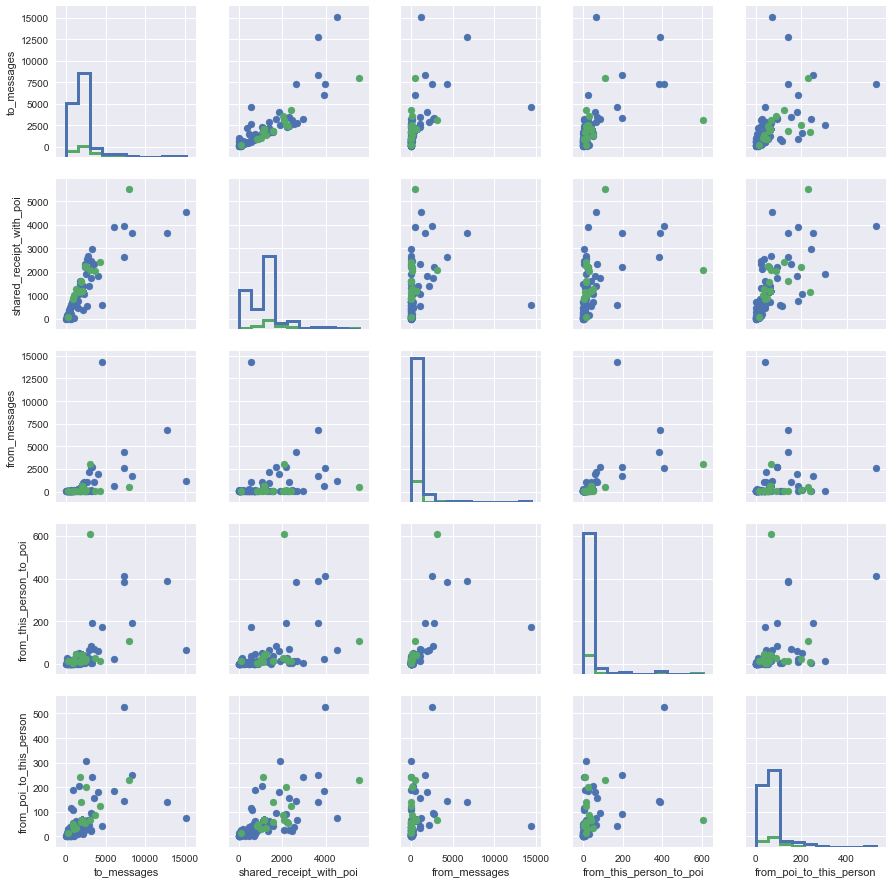   
   
Features had to be scaled (MinMax) in order to allow an appropriate use of algorithm such as k-Nearest Neighbors or SVM... Even if the final selected algorithm was not requiring it, I have kept this step to ensure code consistency among the different steps of the project.

As output, SelectKBest provided the following sorting of features:

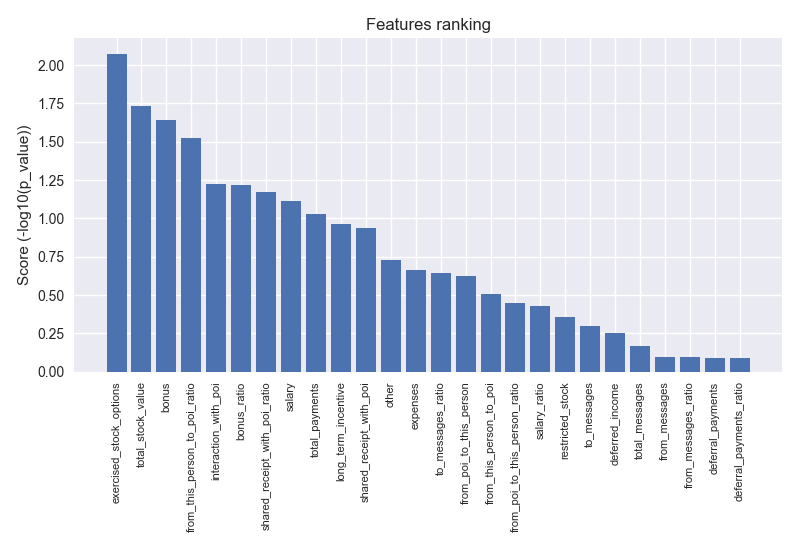

This ranking is showing that some of the engineered features can have a significant power of classification for the poi/no-poi characteristic.

The features selection process was incorporated in the gridSearchCV step using selectKBest. Final classifier was build on the following 15 features that include engineered features for emails traffic and financial figures:

- to_messages,
- exercised_stock_options,
- bonus,
- restricted_stock,
- total_stock_value,
- expenses,
- from_messages,
- from_this_person_to_poi,
- from_poi_to_this_person,
- total_messages,
- shared_receipt_with_poi_ratio,
- from_this_person_to_poi_ratio,
- from_poi_to_this_person_ratio,
- salary_ratio,
- deferral_payments_ratio

## 3/ Algorithms

I have run the following algorithms with their scikit-learn default values on the 10 best features selected from selectKbest:
- Nearest Neighbors
- Linear SVM
- RBF SVM
- Decision Tree
- Random Forest
- AdaBoost
- Naive Bayes

and compare their "raw" performance using score (accuracy), precision and recall metrics as shown on the figure below : 
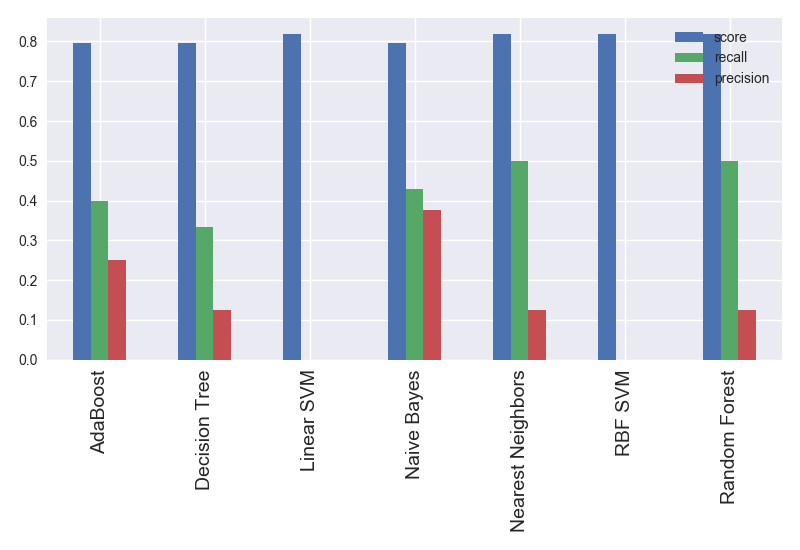

As expected (see part 5/ Validation), the overall accuracy score is not the right criterion to choose among these algorithms as the performance is very similar, even for the ones that cannot identify a single poi (SVM with linear Kernel).

Adaboost and Naive Bayes are the ones providing the most balanced performance between recall and precision. Considering the objective of the project:*"When tester.py is used to evaluate performance, precision and recall are both at least 0.3."*, they seem to be the most suitable choices.

As I wanted to gain some more experience with AdaBoost (that I have considered during lesson 5 of the class *Choose your own algorithm*), I have used this one for a more refined tuning.


## 4/ Algorithm tuning

The adaboost classifier parameters have been tuned using the GridSearchCV function. On top, a pipeline was used in order to tune also the number of features to be used. The table below provides the parameters tuned together with the tested values for each of them:


|Number of features (k)|n_estimators                   |       learning_rate            |
|----------------------|-------------------------------|--------------------------------|
|(2,4,6,8,10,15,20,26) |   (5, 10, 50, 100, 500, 1000) | (0.25, 0.5, 1.0, 2.0, 5.0, 7.5)|

The tuning criterion used is the f1 score as the objective was to reach a balance between recall an precision (see next paragraph).

The following graph summarise the effect of the different parameters on the f1 value:

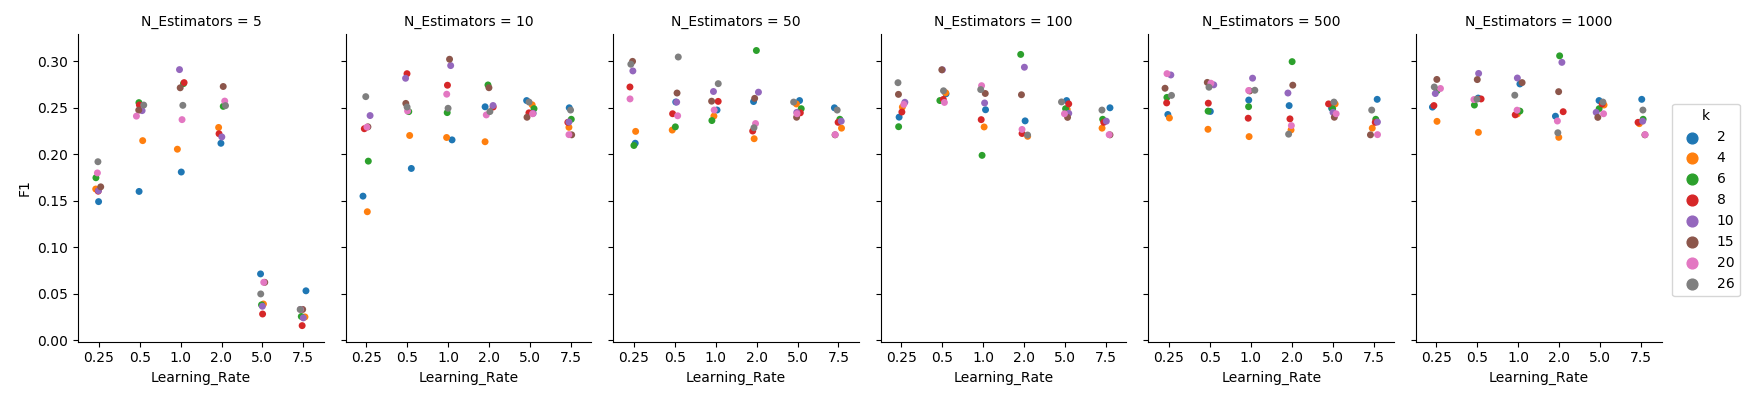

One can see that increasing the number of estimators above 50 does not have an impact on the f1 score on average. As shown on the following graphs, there is an uderlying effect of the Learning Rate parameter that cannot be seen looking only at F1. For Learning rate above 2.0, there is a trade-off between Recall and Precision: improvement in Recall comes at the price of a worse Precision level. This is leading to this kind of constant F1 score whatever the Numbers of estimators above 50.

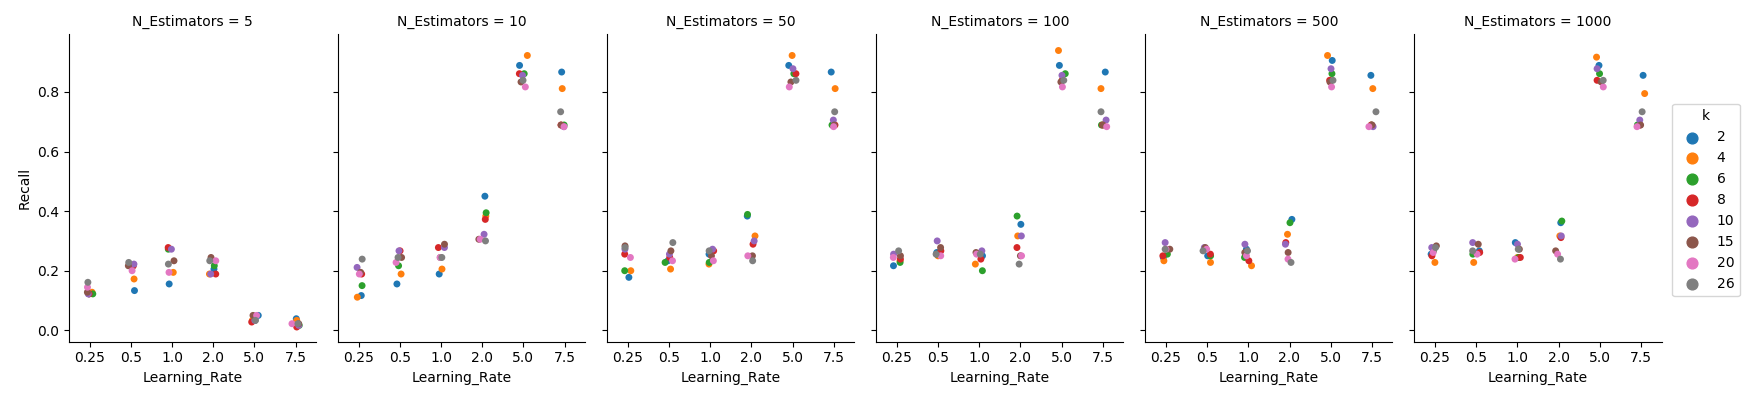
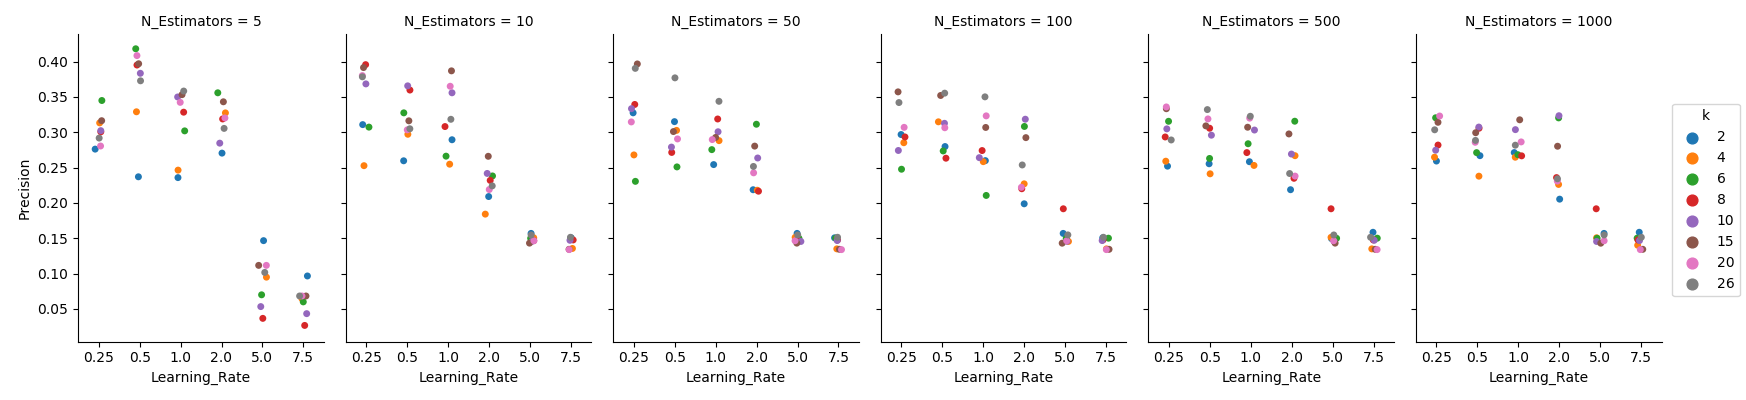

From this point, one can conclude that the best tuning parameters for the adaboost algorithm would be a number of estimators not exceeding 50 and a learning rate below 2.0.

Regarding the number of features, there is no clear tendency. One can nevertheless see that there is no interest to increase this number (and the complexity of the model) too much. A value between 6 and 15 seems reasonnable.

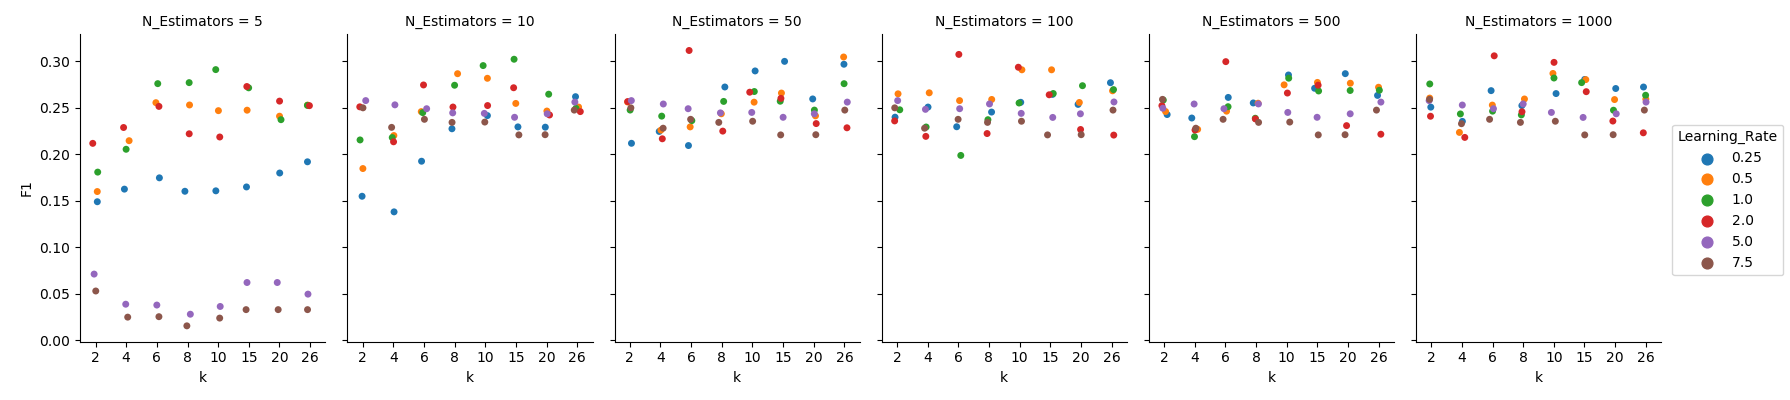

A refined tuning using GridSearchCV around these values lead to the following set of *best* parameters:
- selection_k: 15
- learning_rate: 1.0
- n_estimators: 60


## 5/ Validation

The validation of the classifier was done using the Stratifiedshufflesplit function. A classical train/test split approach was not efficient in this case considering the limited number of datapoints available.

Using this approach enabled to optimise the use of the whole dataset with a limited risk of overfitting.

A classical mistake would have been to consider only the **accuracy** metric as criterion to assess the quality of the classifier. Indeed, as we have an unbalanced dataset with respect to poi/non-poi classes, the accuracy can reach a quite high level (87.5%) corresponding to a classifier putting all individual in the non-poi class. Therefore, considering the **precision** and **recall** metrics is necessary.

## 6/ Classifier performance review

The application of tester.py on the classifier extracted from gridSearchCV lead to the following results:

- Accuracy: 0.83571	
- Precision: 0.40786	
- Recall: 0.33200	
- F1: 0.36604	
- True positives:  664	False positives:  964	False negatives: 1336	True negatives: 11036

And the following confusion matrix:

|                      |Real Positive|Real Negative|
|----------------------|---------------------------|
|Predicted Positive    |  664        |          964|
|Predicted Negative    |  1336       |        11036|

The algorithm is able to retrieve roughly 33% of the poi considering the input features. On the other side, when an individual is classified as positive there is a 40.7% chance that this classification is correct.